# Project 3 -- predicting cloud cover 

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import train_test_split

#%matplotlib notebook

In [2]:
def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log(x/(1-x))

In [3]:
def logit_inv(x): # sigmoid?
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log10((x + 1e-12)/(1+1e-12-x))

# Reading in the data

In [4]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [5]:
#print(cloud.variables)
tcc = cloud.variables["tcc"][:][:][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][:][:][:].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][:][:][:].data

surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [6]:
rel.shape

(32, 6, 61, 77)

In [7]:
# Choosing the number of days for training and testing.

In [8]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(n_days*4):
    TCC.append(tcc[t].flatten())
    #print(rel[t][0].flatten().shape)
    REL.append(rel[t][0].flatten())
    SPE.append(spe[t][0].flatten())
    PRE.append(surf_pre[t].flatten())
    TEMP.append(temp[t].flatten())

y = logit(np.array(TCC).flatten()) #logit(tcc[0].flatten()).reshape((4697, 1))
#x = np.array([rel[t].flatten(), spe[t].flatten(), surf_pre[t].flatten(), temp[t].flatten()]).transpose()

X = np.array([np.array(REL).flatten(),np.array(SPE).flatten(), np.array(PRE).flatten(),np.array(TEMP).flatten()])

In [9]:
y.shape

(131516,)

In [10]:
X.shape

(4, 131516)

In [11]:
X = X.transpose()

In [31]:
X.shape

(131516, 4)


# Regression analysis 

In [13]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


In [14]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [15]:
results["r2_test"]["ridge"]

[[0.18905264785431786,
  0.1890533406272713,
  0.18905405147801235,
  0.18871568306848496,
  0.1855613708753121,
  0.18348997795147604,
  0.18318826918979558,
  0.18315689892515474,
  0.18315495900809564,
  0.18316383337521436]]

In [16]:
results["r2_test"]["ols"]

[[0.19142071302210495]]

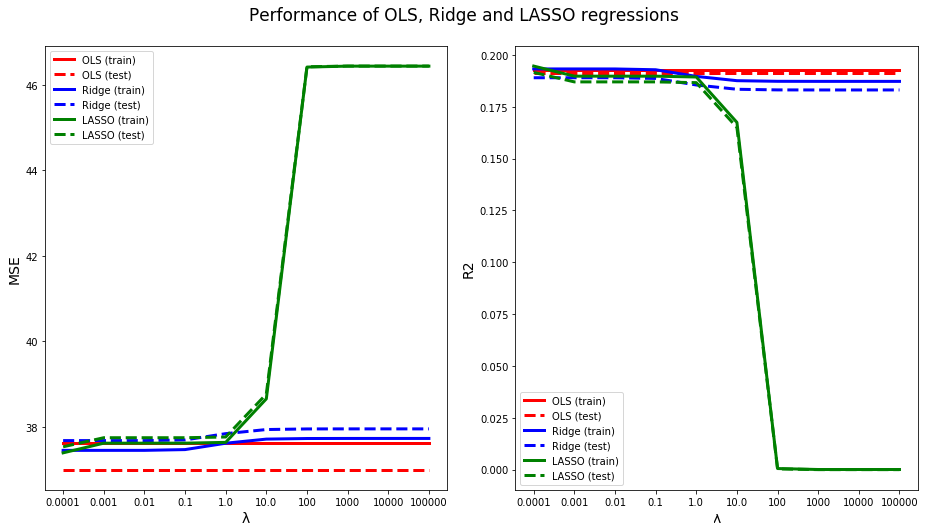

In [17]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [18]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [19]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [20]:
bias

{'ridge': 37.099607230362295,
 'lasso': 37.22134169400363,
 'ols': 37.09982727936224}

In [21]:
var # variance dominates because we don't have so mush data???

{'ridge': 0.0013395868018124465,
 'lasso': 0.0013441435356460268,
 'ols': 0.0014172859277984291}

In [22]:
mse_test

{'ridge': 37.100946817164115,
 'lasso': 37.222685837539274,
 'ols': 37.10124456529004}

In [23]:
bias["ols"] + var["ols"] 

37.10124456529004

In [24]:
bias["ridge"] + var["ridge"] 

37.10094681716411

In [25]:
bias["lasso"] + var["lasso"] 

37.222685837539274

The bias and variance summes to the mse of the ols model.

In [26]:
#logit_inv(z_pred_best["lasso"])

# Compare with scikit learn

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.5)

In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.19774673293999823

In [29]:
model.coef_

array([ 2.11486169e-01, -7.19084581e+02, -1.87450535e-06,  8.55512310e-02])

In [30]:
# relative humidity, specific humidity, pressure, temprature